In [1]:
# Make sure to run the following cells or have the necessary Python libraries available. 

In [2]:
!pip install pandas

In [3]:
!pip install numpy

In [4]:
!pip install matplotlib

In [5]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


Enter the name of the company (or 'exit' to quit):  ASML


Added ASML to portfolio with target price 717.66.


Enter the quantity of ASML stocks to buy:  3


Bought 3.0 of ASML. New quantity: 3.0

Portfolio Value: 2129.70
Transaction History:
Bought 3.0 of ASML

Portfolio Summary:
ASML: Quantity = 3.0, Current Price = 709.90, Target Price = 717.66, VaR (95%) = -0.0411, CVaR (95%) = -0.0728


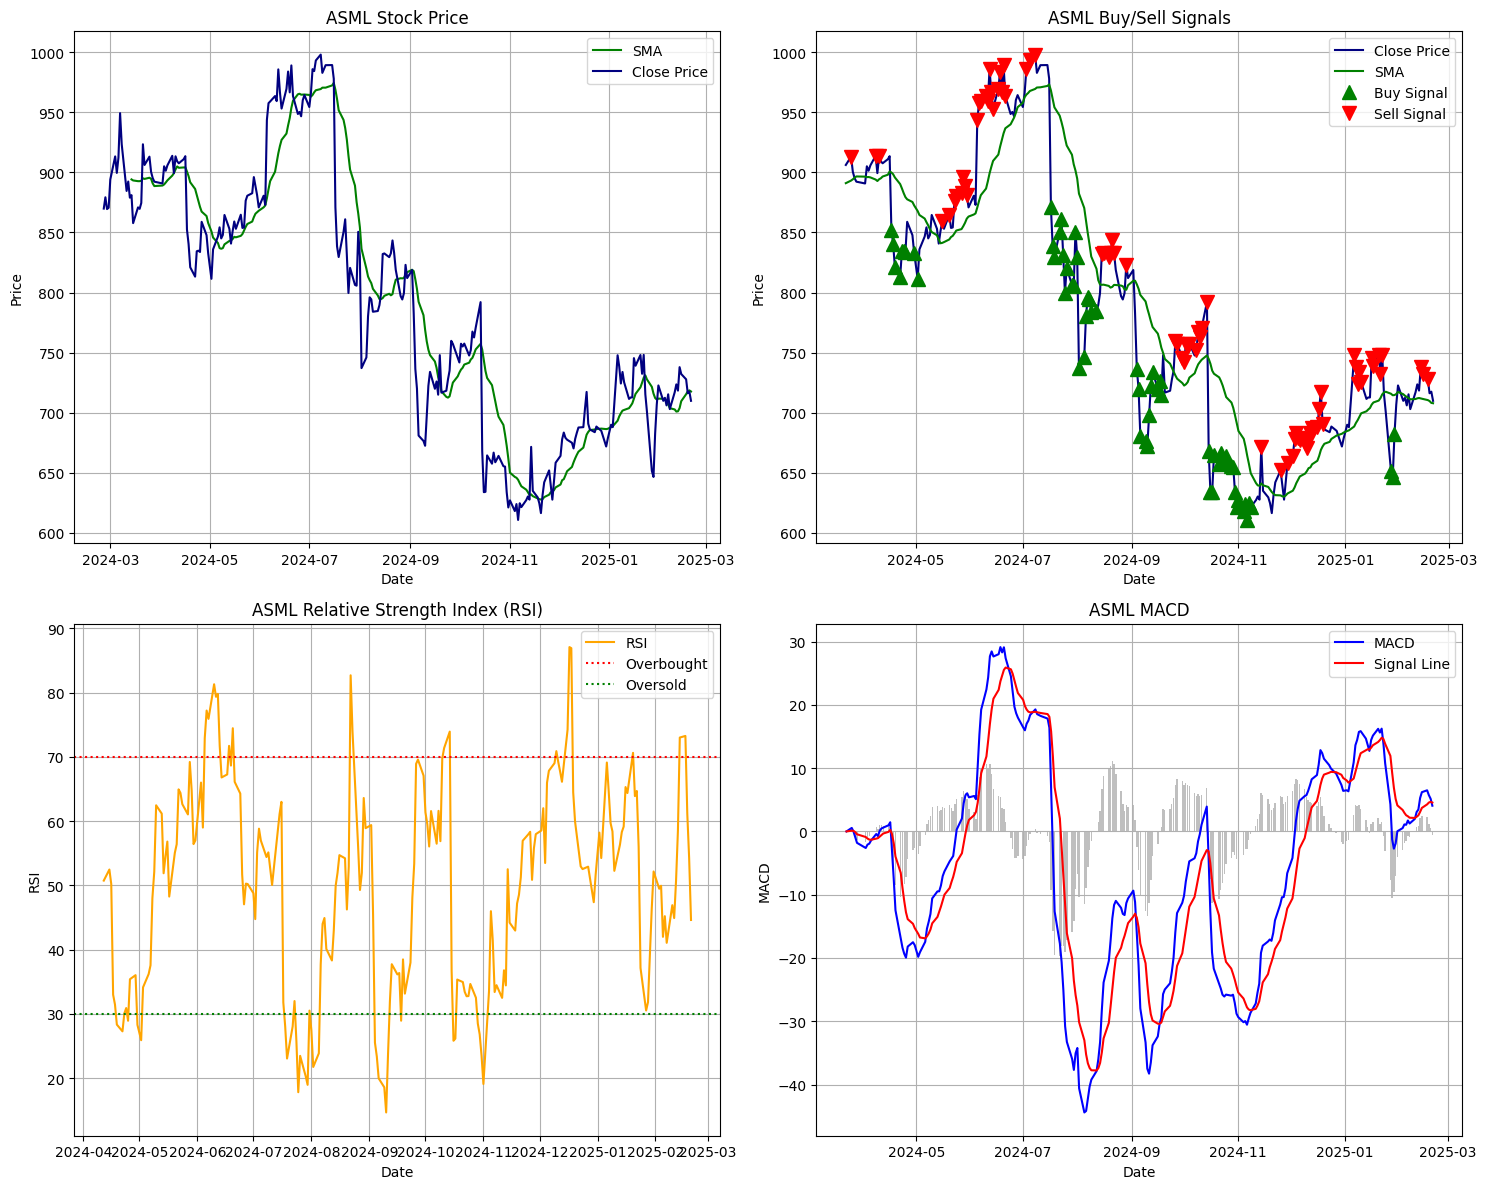


Buy/Sell Signals:
            Close     SMA  Buy_Signal  Sell_Signal
Date                                              
2025-02-14  732.2  711.52       False         True
2025-02-17  727.8  710.51       False         True
2025-02-18  716.2  709.70       False        False
2025-02-19  717.5  708.17       False        False
2025-02-20  709.9  707.90       False        False

Monte Carlo simulation summary: 100 simulations for 360 days
Minimum final price: 672.87
Mean final price: 710.60
Median final price: 712.12
Maximum final price: 745.88
Standard deviation: 17.07


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import os

# Define a base class for assets
class Asset:
    def __init__(self, name):
        self.name = name  # Initialize with the asset's name

    def get_price(self):
        # Method to get the current price of the asset
        # This should be implemented by subclasses
        raise NotImplementedError("Subclasses should implement this method.")

    def monte_carlo_simulation(self, num_simulations, days):
        # Perform a Monte Carlo simulation to predict future prices
        simulations = []
        for _ in range(num_simulations):
            price = self.get_price()
            # Generate random daily changes assuming a normal distribution (with 1.00025^260 ≈ +6.72% yearly and σ = 2.5%)
            daily_changes = np.random.normal(0.00025, 0.025, days)
            # Calculate future prices based on the daily changes
            future_prices = [price * (1 + change) for change in daily_changes]
            simulations.append(future_prices)
        return simulations

# Define a subclass for stocks, inheriting from Asset
class Stock(Asset):
    def __init__(self, name, data_file):
        super().__init__(name)  # Call the initializer of the parent class

        # Load stock data from a CSV file, to download online (Bloomberg, Marketwatch or similar)
        # The data must cover a period from three to twelve months
        self.data = pd.read_csv(data_file)
        self.data['Date'] = pd.to_datetime(self.data['Date'])  # Convert 'Date' to datetime
        self.data.sort_values('Date', inplace=True)  # Sort data by date
        self.data.set_index('Date', inplace=True)  # Set 'Date' as the index

        # Ensure 'Close' prices are numeric and drop any missing values
        self.data['Close'] = pd.to_numeric(self.data['Close'], errors='coerce')
        self.data.dropna(subset=['Close'], inplace=True)

    def get_price(self):
        # Return the most recent closing price
        return self.data['Close'].iloc[-1]

    def plot_metrics(self):
        # Plot various stock metrics
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

        # Plot "Close Price" and "Simple Moving Average" (SMA)
        axes[0, 0].plot(self.data.index, self.data['SMA'], label='SMA', color='green')
        axes[0, 0].plot(self.data.index, self.data['Close'], label='Close Price', color='navy')
        axes[0, 0].set_title(f'{self.name} Stock Price')
        axes[0, 0].set_xlabel('Date')
        axes[0, 0].set_ylabel('Price')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Plot Buy/Sell Signals
        targets = self.calculate_targets()
        axes[0, 1].plot(targets.index, targets['Close'], label='Close Price', color='navy')
        axes[0, 1].plot(targets.index, targets['SMA'], label='SMA', color='green')
        axes[0, 1].plot(targets[targets['Buy_Signal']].index, targets['Close'][targets['Buy_Signal']], '^', markersize=10, color='g', lw=0, label='Buy Signal')
        axes[0, 1].plot(targets[targets['Sell_Signal']].index, targets['Close'][targets['Sell_Signal']], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
        axes[0, 1].set_title(f'{self.name} Buy/Sell Signals')
        axes[0, 1].set_xlabel('Date')
        axes[0, 1].set_ylabel('Price')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Plot "Relative Strength Index" (RSI)
        rsi = self.calculate_rsi()
        axes[1, 0].plot(rsi.index, rsi, label='RSI', color='orange')
        # Add a horizontal line at RSI = 70 to indicate that the asset may be overbought
        axes[1, 0].axhline(y=70, color='red', linestyle='dotted', label='Overbought')
        # Add a horizontal line at RSI = 30 to indicate that the asset may be oversold
        axes[1, 0].axhline(y=30, color='green', linestyle='dotted', label='Oversold')
        axes[1, 0].set_title(f'{self.name} Relative Strength Index (RSI)')
        axes[1, 0].set_xlabel('Date')
        axes[1, 0].set_ylabel('RSI')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Plot "Moving Average Convergence Divergence" (MACD)
        macd, signal = self.calculate_macd()
        axes[1, 1].plot(macd.index, macd, label='MACD', color='blue')
        axes[1, 1].plot(signal.index, signal, label='Signal Line', color='red')
        axes[1, 1].bar(macd.index, macd - signal, color='grey', alpha=0.5)
        axes[1, 1].set_title(f'{self.name} MACD')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('MACD')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def calculate_targets(self, window=20):
        # Calculate Simple Moving Average (SMA) and Buy/Sell signals
        self.data['SMA'] = self.data['Close'].rolling(window=window).mean()
        self.data.dropna(subset=['SMA'], inplace=True)
        self.data['Buy_Signal'] = self.data['Close'] < self.data['SMA'] * 0.96
        self.data['Sell_Signal'] = self.data['Close'] * 0.98 > self.data['SMA']
        return self.data[['Close', 'SMA', 'Buy_Signal', 'Sell_Signal']]

    def calculate_monthly_target_price(self, window=14):
        # Calculate the monthly target price using SMA
        self.data['SMA'] = self.data['Close'].rolling(window=window).mean()
        target_price = self.data['SMA'].iloc[-1]
        return target_price

    def calculate_rsi(self, window=14):
        # Calculate Relative Strength Index (RSI)
        delta = self.data['Close'].diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def calculate_macd(self, short_window=12, long_window=26, signal_window=9):
        # Calculate Moving Average Convergence Divergence (MACD)
        short_ema = self.data['Close'].ewm(span=short_window, adjust=False).mean()
        long_ema = self.data['Close'].ewm(span=long_window, adjust=False).mean()
        macd = short_ema - long_ema
        signal = macd.ewm(span=signal_window, adjust=False).mean()
        return macd, signal

    def calculate_value_at_risk(self, confidence_level=0.95):
        # Calculate Value at Risk (VaR)
        self.data['Log_Return'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        var = self.data['Log_Return'].quantile(1 - confidence_level)
        return var

    def calculate_conditional_value_at_risk(self, confidence_level=0.95):
        # Calculate Conditional Value at Risk (CVaR)
        self.data['Log_Return'] = np.log(self.data['Close'] / self.data['Close'].shift(1))
        var = self.data['Log_Return'].quantile(1 - confidence_level)
        cvar = self.data['Log_Return'][self.data['Log_Return'] < var].mean()
        return cvar

# Define a class for managing a portfolio of assets
class Portfolio:
    def __init__(self):
        self.assets = {}  # Dictionary to store assets
        self.transaction_history = []  # List to store transaction history

    def add_asset(self, asset):
        # Add an asset to the portfolio with a target price
        target_price = asset.calculate_monthly_target_price()
        # Check if the asset already exists in the portfolio
        if asset.name in self.assets:
            # Retain the existing quantity
            quantity = self.assets[asset.name]['quantity']
            print(f"Asset {asset.name} already in portfolio. Retaining quantity: {quantity}")
        else:
            # Initialize quantity to zero for new assets
            quantity = 0
    
        # Update the asset in the portfolio
        self.assets[asset.name] = {'asset': asset, 'target_price': target_price, 'quantity': quantity}
        print(f"Added {asset.name} to portfolio with target price {target_price:.2f}.")

    def buy_asset(self, name, quantity):
        # Buy a specified quantity of an asset
        if name in self.assets:
            self.assets[name]['quantity'] += quantity
            self.transaction_history.append(f"Bought {quantity} of {name}")
            print(f"Bought {quantity} of {name}. New quantity: {self.assets[name]['quantity']}")
        else:
            print(f"Asset {name} not found in portfolio.")

    def sell_asset(self, name, quantity):
        # Sell a specified quantity of an asset
        if name in self.assets and self.assets[name]['quantity'] >= quantity:
            self.assets[name]['quantity'] -= quantity
            self.transaction_history.append(f"Sold {quantity} of {name}")
            print(f"Sold {quantity} of {name}. Remaining quantity: {self.assets[name]['quantity']}")
        else:
            print(f"Not enough quantity of {name} to sell.")

    def get_portfolio_value(self):
        # Calculate the total value of the portfolio
        total_value = 0
        for asset_info in self.assets.values():
            total_value += asset_info['asset'].get_price() * asset_info['quantity']
        return total_value

    def print_transaction_history(self):
        # Print the transaction history
        print("Transaction History:")
        for transaction in self.transaction_history:
            print(transaction)

    def print_portfolio_summary(self):
        # Print a summary of the portfolio
        print("\nPortfolio Summary:")
        for name, asset_info in self.assets.items():
            asset = asset_info['asset']
            quantity = asset_info['quantity']
            target_price = asset_info['target_price']
            current_price = asset.get_price()
            var = asset.calculate_value_at_risk()
            cvar = asset.calculate_conditional_value_at_risk()
            print(f"{name}: Quantity = {quantity}, Current Price = {current_price:.2f}, Target Price = {target_price:.2f}, VaR (95%) = {var:.4f}, CVaR (95%) = {cvar:.4f}")

def main(portfolio):
    while True:
        company_name = input("Enter the name of the company (or 'exit' to quit): ")
        if company_name.lower() == 'exit':
            break

        # Manually set the base directory (adjust this path as needed)
        base_dir = os.getcwd()  # This gets the current working directory
        # Construct the full path to the data file
        data_file = os.path.join(base_dir, 'Data', f'{company_name}.csv')

        try:
            stock = Stock(name=company_name, data_file=data_file)
            portfolio.add_asset(stock)

            quantity = float(input(f"Enter the quantity of {company_name} stocks to buy: "))
            portfolio.buy_asset(company_name, quantity)

            print(f"\nPortfolio Value: {portfolio.get_portfolio_value():.2f}")
            portfolio.print_transaction_history()
            portfolio.print_portfolio_summary()

            stock.plot_metrics()

            targets = stock.calculate_targets()
            print("\nBuy/Sell Signals:")
            print(targets.tail())

            # Assuming 'stock' is an object with a method 'monte_carlo_simulation'
            num_simulations = 100  # Define the number of simulations
            days = 360  # Define the number of days

            simulations = stock.monte_carlo_simulation(num_simulations=num_simulations, days=days)
            final_prices = [sim[-1] for sim in simulations]

            min_price = min(final_prices)
            max_price = max(final_prices)
            median_price = np.median(final_prices)
            mean_price = np.mean(final_prices)
            std_price = np.std(final_prices)

            print(f"\nMonte Carlo simulation summary: {num_simulations:.0f} simulations for {days:.0f} days")
            print(f"Minimum final price: {min_price:.2f}")
            print(f"Mean final price: {mean_price:.2f}")
            print(f"Median final price: {median_price:.2f}")
            print(f"Maximum final price: {max_price:.2f}")
            print(f"Standard deviation: {std_price:.2f}")

        except Exception as e:
            print(f"An error occurred: {e}")

# Initialize the portfolio outside the main function
portfolio = Portfolio()

# Call the main function with the portfolio object
main(portfolio)